In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from unidecode import unidecode
import nltk
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import numpy as np 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from itertools import chain 
from nltk.tokenize import word_tokenize

In [2]:
df = pd.read_csv('youtube_video_data_with_comments.csv')  

In [3]:
data = df[['comment_author', 'Title']].copy()


In [4]:
user_counts = data['comment_author'].value_counts()
common_users = user_counts[user_counts > 1].index
filtered_data = data[data['comment_author'].isin(common_users)]


In [5]:
G = nx.Graph()

for index, row in filtered_data.iterrows():
    G.add_edge(row['Title'], row['comment_author'])


In [6]:
common_users = set()
for node in G.nodes:
    neighbors = set(G.neighbors(node))
    if len(neighbors) > 1:
        common_users.update(neighbors)


In [7]:
len(common_users)

570

Comment Count of user in each video

In [8]:
# Iterate through unique video names
for title in data['Title'].unique():
    # Filter data for the current video
    title = data[data['Title'] == title]

    # Find the number of comments each common user made in the current video
    comment_counts = title['comment_author'].value_counts()
    
    data['video_comment_count'] = data.groupby('Title')['comment_author'].transform('count')


In [9]:
# Convert the 'video_comment_count' column to integers and replace NaN values with 0
data['video_comment_count'] = data['video_comment_count'].fillna(0).astype(int)


Adding new column commented_video to save all the video titles on which a user has commented.

In [10]:
# Group data by 'comment_author' and get unique video titles as a set
user_subreddit_sets = data.groupby('comment_author')['Title'].apply(set).reset_index()

# Merge the aggregated data back into the original DataFrame
data = data.merge(user_subreddit_sets, on='comment_author', suffixes=('', '_set'))

# Rename the new column to 'commented_video'
data.rename(columns={'Title_set': 'commented_video'}, inplace=True)


In [11]:
data.head(5)

,comment_author,Title,video_comment_count,commented_video
0,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....
1,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....
2,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....
3,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....
4,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....


In [12]:
# Add a new column 'num_commented_videos' to store the count
data['num_commented_videos'] = data['commented_video'].apply(lambda x: len(x))


In [13]:
data.head(10)

,comment_author,Title,video_comment_count,commented_video,num_commented_videos
0,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
1,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
2,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
3,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
4,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
5,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
6,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
7,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
8,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2
9,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2


Calculates total number of comments of a user in all the subreddits

In [14]:
# Calculate the total comment count for each user
user_total_comment_counts = data['comment_author'].value_counts().reset_index()
user_total_comment_counts.columns = ['comment_author', 'total_comment_count']

# Merge the total comment counts back into the original DataFrame
data = data.merge(user_total_comment_counts, on='comment_author', how='left')


In [15]:
data.head(10)

,comment_author,Title,video_comment_count,commented_video,num_commented_videos,total_comment_count
0,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
1,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
2,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
3,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
4,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
5,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
6,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
7,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
8,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
9,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51


In [19]:
data.to_csv("User_Network_Data_YouTube.csv", index=False)

Function to create bar graph

In [26]:
# Function to create a bar graph for the top 50 users in a subreddit
def create_bar_graph(title):
    title_data = data[data['Title'] == title]
    comment_counts = title_data['comment_author'].value_counts()
    top_users = comment_counts.nlargest(25)

    plt.figure(figsize=(16, 10))
    plt.barh(top_users.index, top_users.values)
    plt.gca().invert_yaxis()
    plt.xlabel('Total Comments')
    plt.ylabel('User')
    plt.title(f'Top 25 Users in {title}')
    plt.tight_layout()

In [22]:
data['Title'].unique()



array(['The stages of F.I.R.E. (Financial Independence, Retire Early)',
       '5 truths I wish I knew before starting F.I.R.E. (Financial Independence, Retire Early)',
       'Retired Early with Over $4 Million, But Not Enjoying It!',
       'How to Achieve FIRE By Income (Are You on Track?)',
       'How To Actually Retire In 7 Years (Starting With $0)',
       'The Dark Side of F.I.R.E. (Financial Independence, Retire Early)',
       'Master Your Money: The Ultimate Budget for Financial Independence and Retiring Early',
       "Why the FIRE Movement doesn't work (Financial Independence, Retire Early)",
       '10 Levels of Financial Independence And Early Retirement | How to Retire Early',
       "The Dark Truth of Financial Independence Retire Early (FIRE) | What They Don't Tell You",
       'Our Plan to Retire in 8 Years | Financial Independence Retire Early | $1.9MM Target',
       'How We Retired Early With $540K At 40 In Colorado',
       'How We Retired Early With $2.2 Million

Creating bar grapgh to show top 50 users in subreddit 'Fire'

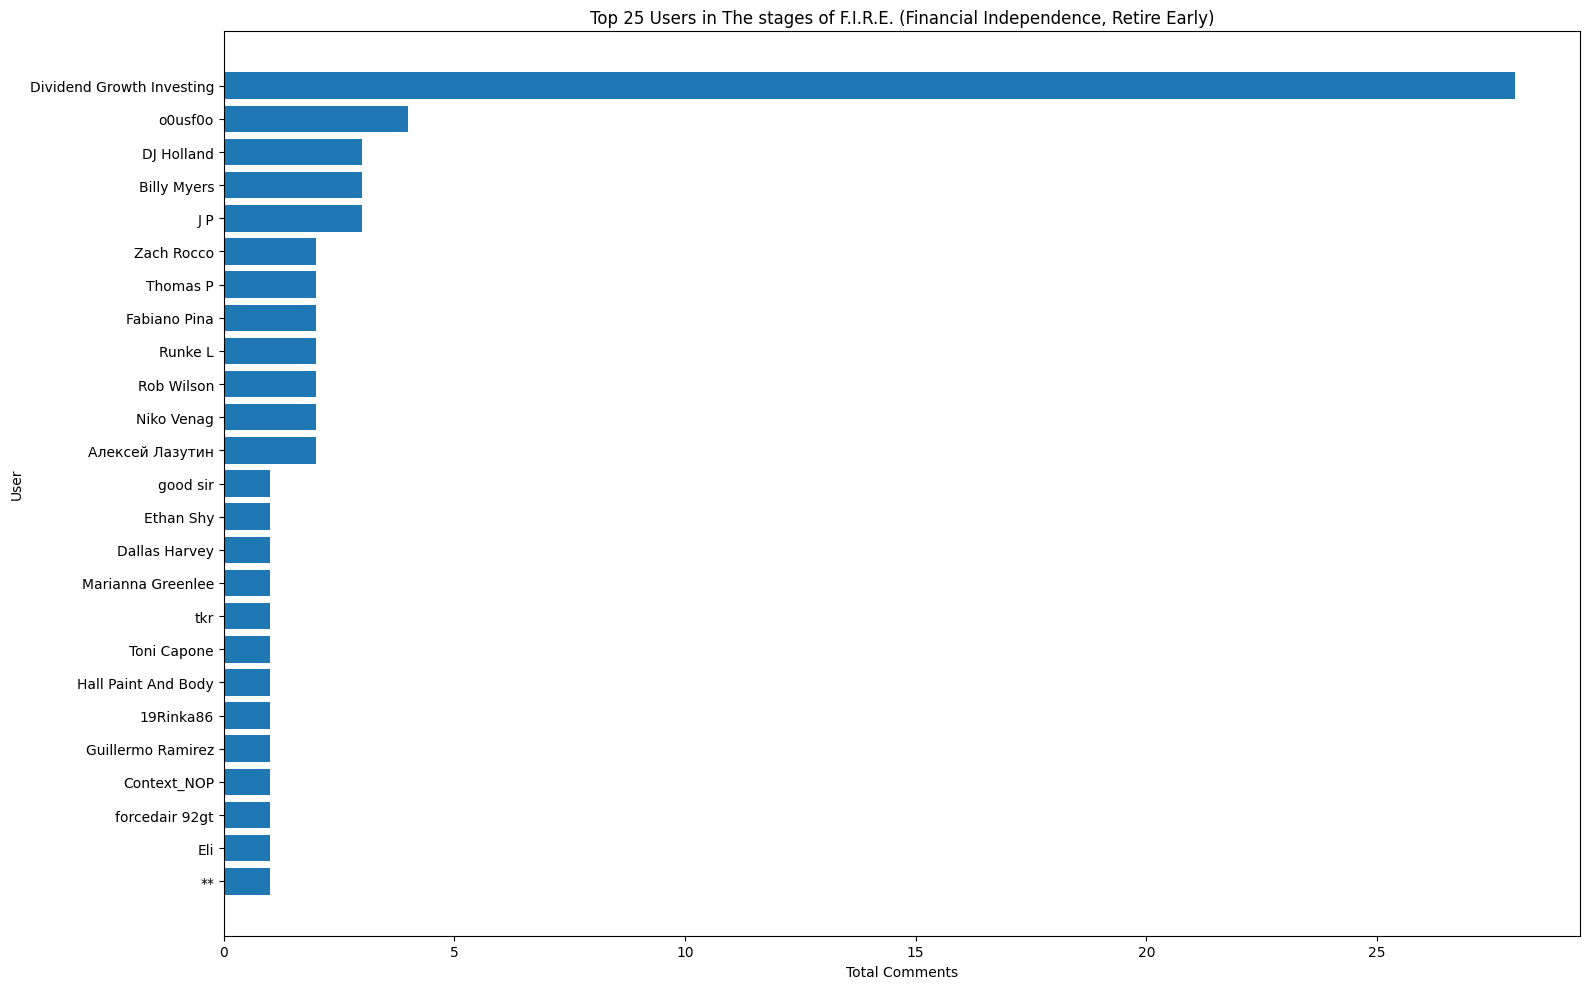

In [27]:
create_bar_graph('The stages of F.I.R.E. (Financial Independence, Retire Early)')

Creating bar grapgh to show top 50 users in subreddit 'FinancialPlanning'

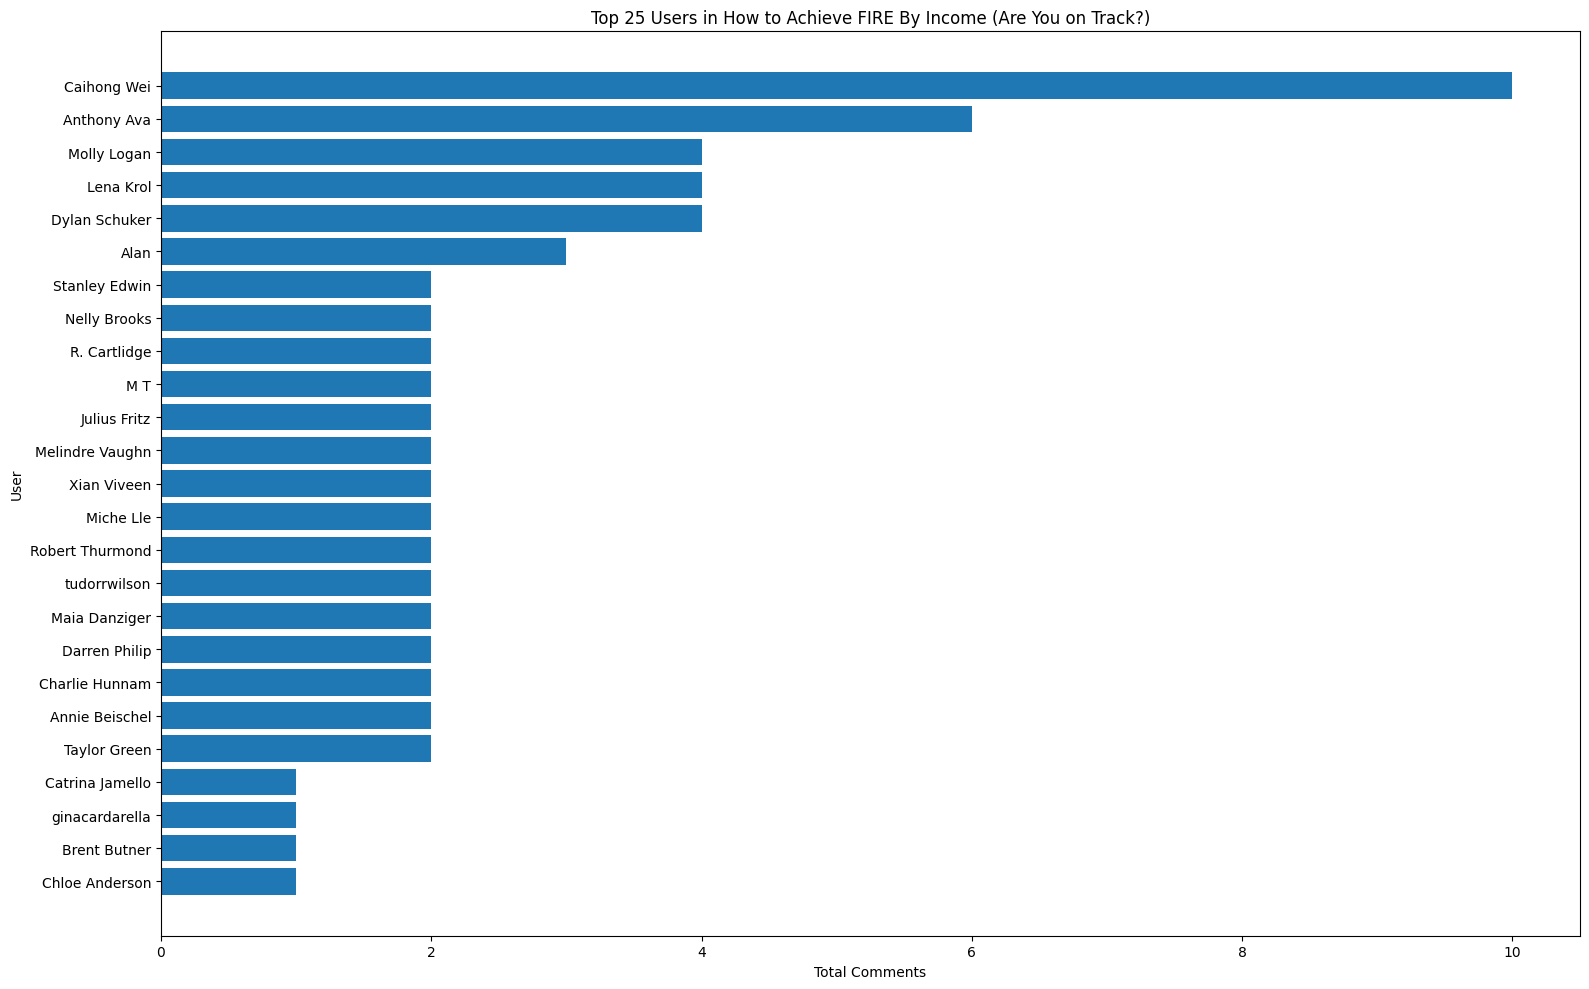

In [28]:
create_bar_graph('How to Achieve FIRE By Income (Are You on Track?)')

/var/folders/04/ddnzk_jn2q9c2h6h29yd405w0000gn/T/ipykernel_73860/1233196568.py:11: UserWarning: Glyph 9461 (\N{DOUBLE CIRCLED DIGIT ONE}) missing from current font.
  plt.tight_layout()
/var/folders/04/ddnzk_jn2q9c2h6h29yd405w0000gn/T/ipykernel_73860/1233196568.py:11: UserWarning: Glyph 9465 (\N{DOUBLE CIRCLED DIGIT FIVE}) missing from current font.
  plt.tight_layout()
/var/folders/04/ddnzk_jn2q9c2h6h29yd405w0000gn/T/ipykernel_73860/1233196568.py:11: UserWarning: Glyph 9450 (\N{CIRCLED DIGIT ZERO}) missing from current font.
  plt.tight_layout()
/var/folders/04/ddnzk_jn2q9c2h6h29yd405w0000gn/T/ipykernel_73860/1233196568.py:11: UserWarning: Glyph 9462 (\N{DOUBLE CIRCLED DIGIT TWO}) missing from current font.
  plt.tight_layout()
/var/folders/04/ddnzk_jn2q9c2h6h29yd405w0000gn/T/ipykernel_73860/1233196568.py:11: UserWarning: Glyph 9466 (\N{DOUBLE CIRCLED DIGIT SIX}) missing from current font.
  plt.tight_layout()
/var/folders/04/ddnzk_jn2q9c2h6h29yd405w0000gn/T/ipykernel_73860/1233196568

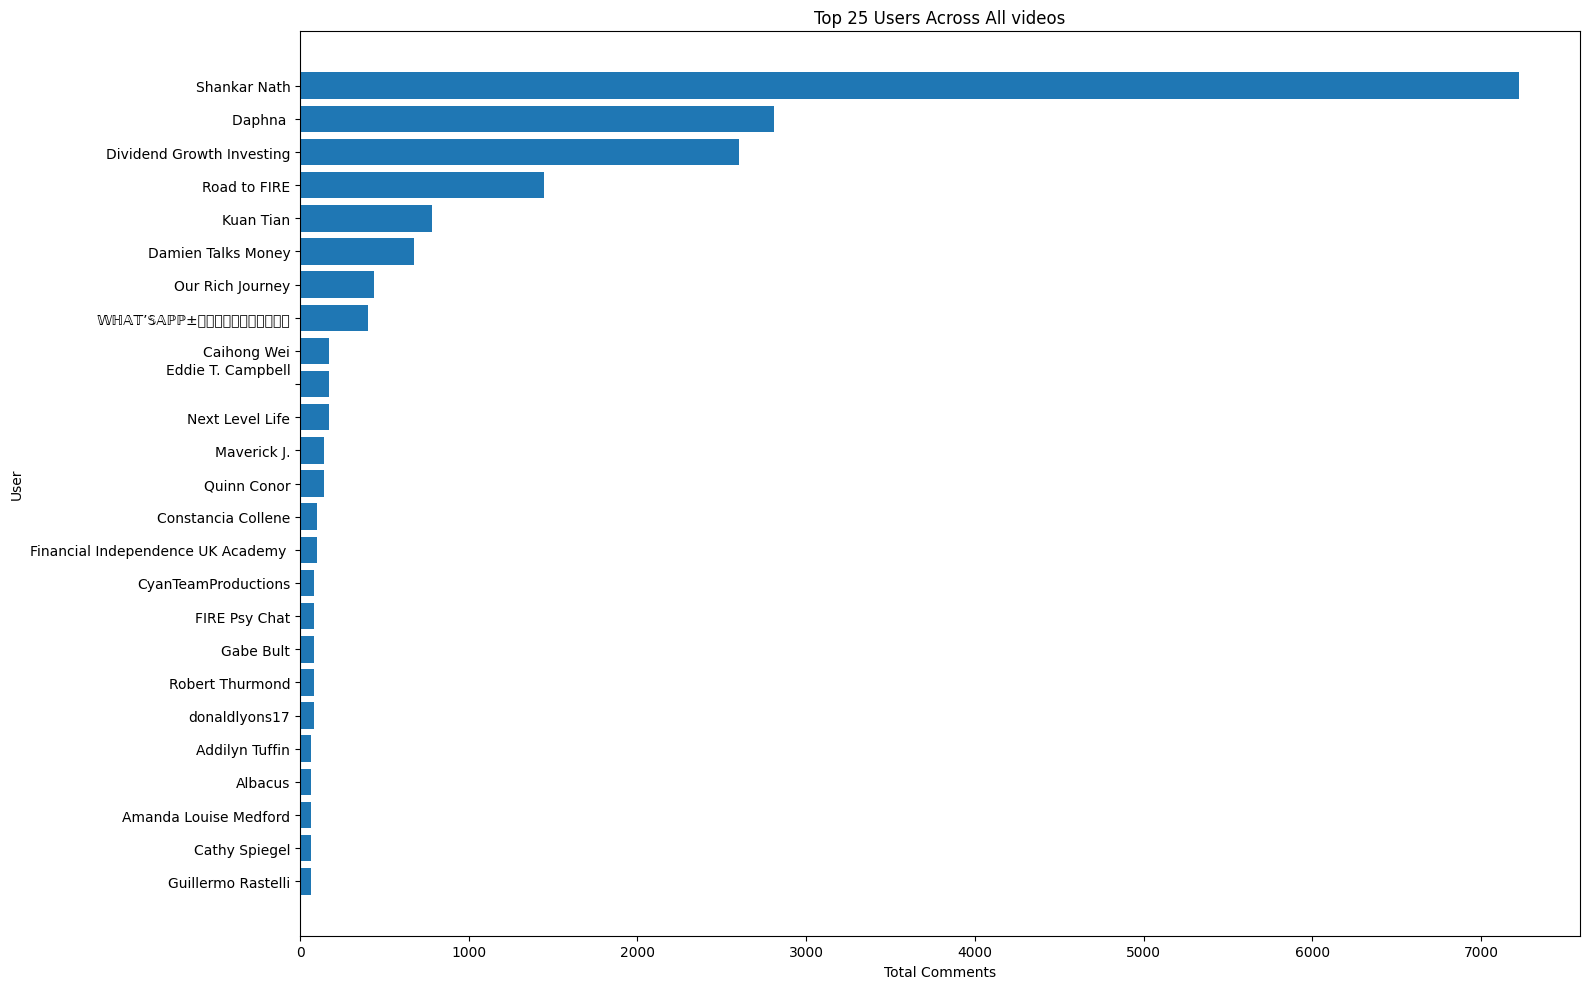

In [29]:
# Get the top 50 users who commented across all subreddits
top_users_all_videos = data[['comment_author', 'total_comment_count']].groupby('comment_author').sum().nlargest(25, 'total_comment_count')

# Create a bar graph for the top 50 users across all subreddits
plt.figure(figsize=(16, 10))
plt.barh(top_users_all_videos.index, top_users_all_videos['total_comment_count'])
plt.gca().invert_yaxis()
plt.xlabel('Total Comments')
plt.ylabel('User')
plt.title('Top 25 Users Across All videos')
plt.tight_layout()
plt.savefig('Top_25_Users_All_Subreddits.png')

In [30]:
# Filter for users who have commented in at least three unique subreddits
common_users_in_3_videos = data[data['num_commented_videos'] >= 3]['comment_author'].unique()

# Display or save the list of common users
print("Common users who commented in at least three videos:")
print(common_users_in_3_videos)

Common users who commented in at least three videos:
['Fabiano Pina' 'On Cash Flow' 'thelastunicorn1987' 'Bastian Russo'
 'Bobby Blue' 'colleen Odegaard' 'Emmanuel' 'Addilyn Tuffin' 'Albacus'
 'Robinson Baker' 'Eric Wilde' 'Julie Hyde' 'Raul Romero' 'RS'
 'Cars Simplified' 'Brillian Tran ' 'Justin Meyer' 'Eric' 'liu zhang'
 'Quinn Conor' 'Rodrigo Hernandez' 'Financial Independence UK Academy '
 'Jonathan Nathan' 'Dorian Jacobs' 'Robert Thurmond' 'soja kia'
 'Stefanie Marine' 'Walter.D Lawson' 'Michael Brenner' 'donaldlyons17'
 'Freeman Booth' 'Cathy Spiegel' 'Bernard Wright' 'Oleksiy Matviyenko' 'B'
 'Taylor Green' 'FIRE' 'Darnell Capriccioso' 'Tatiana Starcic']


In [33]:
# Filter for users who have commented on more than three subreddits
users_with_more_than_3_videos = data[data['commented_video'].str.len() > 3]

# Create a set to store unique combinations of users and their commented subreddits
unique_combinations = set()

# Iterate through the DataFrame to display unique combinations
for _, row in users_with_more_than_3_videos.iterrows():
    user = row['comment_author']
    videos = sorted(row['commented_video'])  # Sort the subreddits for consistency
    unique_combinations.add((user, tuple(videos)))

# Display unique combinations
for combination in unique_combinations:
    user, videos = combination
    print(f'User: {user}')
    print(f' Num of Commented videos: {len(videos)}')

User: thelastunicorn1987
 Num of Commented videos: 6
User: Emmanuel
 Num of Commented videos: 4
User: Robert Thurmond
 Num of Commented videos: 4
User: liu zhang
 Num of Commented videos: 4
User: Cathy Spiegel
 Num of Commented videos: 4
User: On Cash Flow
 Num of Commented videos: 6
User: Eric
 Num of Commented videos: 4
User: Eric Wilde
 Num of Commented videos: 4
User: Addilyn Tuffin
 Num of Commented videos: 5
User: Quinn Conor
 Num of Commented videos: 4
User: Financial Independence UK Academy 
 Num of Commented videos: 9
User: donaldlyons17
 Num of Commented videos: 4


In [35]:

# Filter for users who have commented on more than three subreddits
users_with_more_than_3_videos = data[data['commented_video'].str.len() > 3]

# Create a list to store unique combinations of users, subreddits, and total comments
unique_combinations = []

# Create a set to track already added combinations
added_combinations = set()

# Iterate through the DataFrame to collect unique combinations
for _, row in users_with_more_than_3_videos.iterrows():
    user = row['comment_author']
    videos = tuple(sorted(row['commented_video']))  # Convert set to a tuple for hashing
    total_comments = row['total_comment_count']
    
    # Represent the combination as a tuple
    combination = (user, videos, total_comments)

    # Check if the combination is unique
    if combination not in added_combinations:
        unique_combinations.append(combination)
        added_combinations.add(combination)

# Display unique combinations
for combination in unique_combinations:
    user, videos, total_comments = combination
    print(f'User: {user}')
    print(f'Num of Commented Videos: {len(videos)}')
    print(f'Total Comments: {total_comments}')
    print()




User: On Cash Flow
Num of Commented Videos: 6
Total Comments: 6

User: thelastunicorn1987
Num of Commented Videos: 6
Total Comments: 7

User: Emmanuel
Num of Commented Videos: 4
Total Comments: 5

User: Addilyn Tuffin
Num of Commented Videos: 5
Total Comments: 8

User: Eric Wilde
Num of Commented Videos: 4
Total Comments: 5

User: Eric
Num of Commented Videos: 4
Total Comments: 5

User: liu zhang
Num of Commented Videos: 4
Total Comments: 7

User: Quinn Conor
Num of Commented Videos: 4
Total Comments: 12

User: Financial Independence UK Academy 
Num of Commented Videos: 9
Total Comments: 10

User: Robert Thurmond
Num of Commented Videos: 4
Total Comments: 9

User: donaldlyons17
Num of Commented Videos: 4
Total Comments: 9

User: Cathy Spiegel
Num of Commented Videos: 4
Total Comments: 8



In [36]:
common_users_in_8_videos =  data[data['num_commented_videos'] >= 8]['comment_author'].unique()
# Display or save the list of common users
print("Common users who commented in at least three videos:")
print(common_users_in_8_videos)

Common users who commented in at least three videos:
['Financial Independence UK Academy ']


In [37]:
# Filter the data based on 'num_commented_videos' greater than 1
filtered_data = data[data['num_commented_videos'] > 1]


In [38]:
filtered_data.head(10)

,comment_author,Title,video_comment_count,commented_video,num_commented_videos,total_comment_count
0,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
1,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
2,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
3,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
4,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
5,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
6,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
7,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
8,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51
9,Dividend Growth Investing,The stages of F.I.R.E. (Financial Independence...,87,{5 truths I wish I knew before starting F.I.R....,2,51


In [39]:
# Create a graph
G = nx.Graph()

# Iterate through filtered data to add nodes and edges
for _, row in filtered_data.iterrows():
    user = row['comment_author']
    Videos = row['commented_video']
    
    # Add user node if not already present
    if not G.has_node(user):
        G.add_node(user, type='user')
    
    # Add subreddit nodes and edges
    for video in Videos:
        if not G.has_node(video):
            G.add_node(video, type='video')
        G.add_edge(user, video)

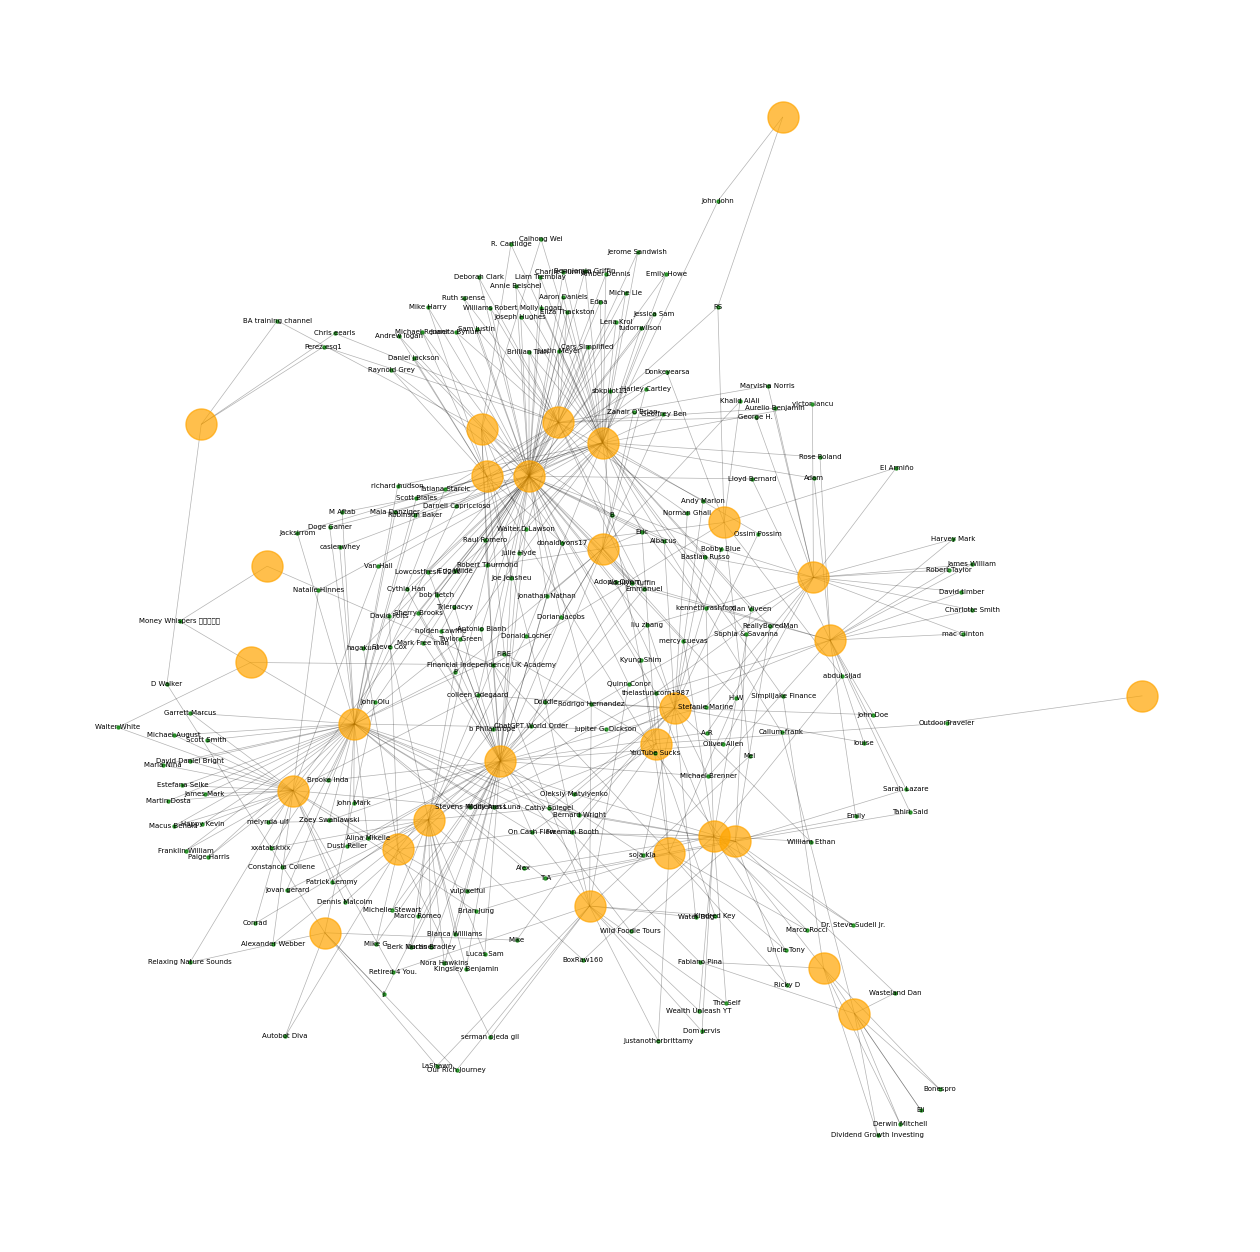

In [43]:

# Create a layout for visualization
pos = nx.spring_layout(G)

# Decrease the size of user nodes and increase the size of the entire graph
user_node_size = 5
video_node_size = 500
plt.figure(figsize=(16, 16))

# Draw nodes
user_nodes = {n for n, d in G.nodes(data=True) if d['type'] == 'user'}
video_nodes = set(G) - user_nodes


# Draw labels (optional)
nx.draw_networkx_nodes(G, pos, nodelist=video_nodes, node_color='orange', node_size=video_node_size, node_shape='o', alpha=0.7)
labels = {node: node for node in user_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=5)


nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='green', node_size=user_node_size, node_shape='o', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)

# Set axis off for cleaner visualization
plt.axis('off')

# Show the graph
plt.show()

In [44]:
# Create a graph from your data
G = nx.from_pandas_edgelist(data, source='comment_author', target='Title')

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Add degree centrality values to the original DataFrame
data['degree_centrality'] = data['comment_author'].map(degree_centrality)

In [45]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Add betweenness centrality values to the original DataFrame
data['betweenness_centrality'] = data['comment_author'].map(betweenness_centrality)


In [46]:
# Create a DataFrame to store user names, degree centrality, and betweenness centrality
unique_users = data['comment_author'].unique()

centrality_data = pd.DataFrame({
    'comment_author': unique_users,
    'degree_centrality': [degree_centrality.get(user, 0) for user in unique_users],
    'betweenness_centrality': [betweenness_centrality.get(user, 0) for user in unique_users]
})

In [48]:
centrality_data.head(10)

,comment_author,degree_centrality,betweenness_centrality
0,Dividend Growth Investing,0.000679,0.000274
1,the.hippie.spirit,0.000339,0.000000
2,Adoring Your Hair,0.000339,0.000000
3,Riley Kate,0.000339,0.000000
4,Derwin Mitchell,0.000679,0.000274
5,Pure Water Window Cleaning,0.000339,0.000000
6,Алексей Лазутин,0.000339,0.000000
7,Niko Venag,0.000339,0.000000
8,Wasteland Dan,0.000679,0.003254
9,Callum-frank,0.000679,0.008923


In [49]:
# Find the user with the maximum degree centrality in the DataFrame
max_degree_user = data.loc[data['degree_centrality'].idxmax()]

print("User with maximum degree centrality:", max_degree_user['comment_author'])
print("Degree centrality:", max_degree_user['degree_centrality'])

User with maximum degree centrality: Financial Independence UK Academy 
Degree centrality: 0.0030539531727180186


In [52]:
# Sort the DataFrame by 'degree_centrality' in descending order
sorted_centrality_data = data.sort_values(by='degree_centrality', ascending=False)

# Deduplicate the data to keep unique users
unique_users = sorted_centrality_data.drop_duplicates(subset='comment_author')

# Get the top 10 unique users with the highest degree centrality
top_1000_unique_users = unique_users.head(1000)

# Display the top 10 unique users with the highest degree centrality
print("Top 1000 unique users with the highest degree centrality:")
print(top_1000_unique_users[['comment_author', 'degree_centrality']])


Top 1000 unique users with the highest degree centrality:
                          comment_author  degree_centrality
508   Financial Independence UK Academy            0.003054
152                         On Cash Flow           0.002036
233                   thelastunicorn1987           0.002036
270                       Addilyn Tuffin           0.001697
1427                       Cathy Spiegel           0.001357
...                                  ...                ...
3724                   D'Artagnan Harris           0.000339
3725                        Li Christine           0.000339
3726                                marg           0.000339
3727                         Cindy Brown           0.000339
3728                     The Expendables           0.000339

[1000 rows x 2 columns]


In [54]:
# Sort the top 1000 users by 'total_comment_count' in descending order
sorted_top_1000_comment_users = top_1000_unique_users.sort_values(by='total_comment_count', ascending=False)

# Get the top 25 users with the highest total comment count from the top 1000 users
top_25_comment_users = sorted_top_1000_comment_users.head(25)

# Display the top 20 users with the highest total comment count from the top 1000 users
print("Top 25 users with the highest total comment count from the top 1000 users according to centrality:")
print(top_25_comment_users[['comment_author', 'total_comment_count','num_commented_videos']])


Top 25 users with the highest total comment count from the top 1000 users according to centrality:
                          comment_author  total_comment_count  \
4022                        Shankar Nath                   85   
3233                             Daphna                    53   
1              Dividend Growth Investing                   51   
3758                        Road to FIRE                   38   
1630                    Our Rich Journey                   21   
1498                         Caihong Wei                   13   
460                          Quinn Conor                   12   
508   Financial Independence UK Academy                    10   
1752                  Constancia Collene                   10   
4269                       FIRE Psy Chat                    9   
2982                 CyanTeamProductions                    9   
1282                       donaldlyons17                    9   
591                      Robert Thurmond                

In [55]:
# Explode the 'commented_subreddit' column to create user-subreddit pairs
exploded_df = top_25_comment_users.explode('commented_video')

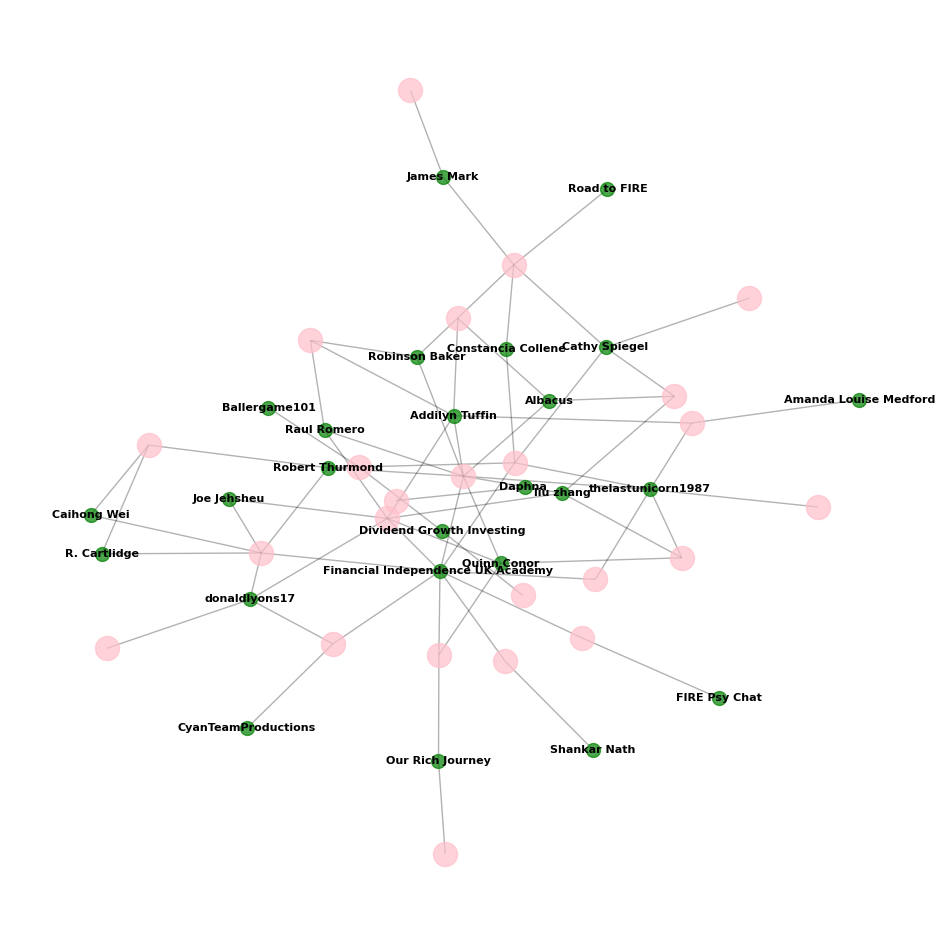

In [63]:
# Create a graph
G = nx.Graph()

# Add nodes for users and videos
users = exploded_df['comment_author'].unique()
videos = exploded_df['commented_video'].unique()

G.add_nodes_from(users, type='user')
G.add_nodes_from(videos, type='subreddit')

# Create edges between users and their commented videos
user_video_pairs = exploded_df[['comment_author', 'commented_video']].values
G.add_edges_from(user_video_pairs)

# Create a layout using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# Visualize the graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=users, node_color='green', node_size=100, node_shape='o', alpha=0.7)
nx.draw_networkx_nodes(G, pos, nodelist=videos, node_color='pink', node_size=300, node_shape='o', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3)

# Add labels for usernames
user_labels = {node: node for node in users}
nx.draw_networkx_labels(G, pos, labels=user_labels, font_size=8, font_weight='bold')

# Set axis off for cleaner visualization
plt.axis('off')

# Show the graph
plt.show()


In [64]:
# Extract the usernames of the top 25 users
top_25_usernames = top_25_comment_users['comment_author']

# Filter the original dataset to get comments for the top 25 users
comments_for_top_25_users = df[df['comment_author'].isin(top_25_usernames)]


In [65]:
comments_for_top_25_users

,Video ID,Title,Description,View Count,Like Count,Comment Count,Upload Date,Channel Name,Comment,comment_author
0,PMz5yIzPHjo,The stages of F.I.R.E. (Financial Independence...,There are many paths that can lead to success ...,17711,616,87,2023-06-25T22:04:28Z,Dividend Growth Investing,Which stage are you working towards?\r\nTry M1...,Dividend Growth Investing
3,PMz5yIzPHjo,The stages of F.I.R.E. (Financial Independence...,There are many paths that can lead to success ...,17711,616,87,2023-06-25T22:04:28Z,Dividend Growth Investing,Glad it was helpful!,Dividend Growth Investing
5,PMz5yIzPHjo,The stages of F.I.R.E. (Financial Independence...,There are many paths that can lead to success ...,17711,616,87,2023-06-25T22:04:28Z,Dividend Growth Investing,You could invest 19k or so in a 401k + your em...,Dividend Growth Investing
7,PMz5yIzPHjo,The stages of F.I.R.E. (Financial Independence...,There are many paths that can lead to success ...,17711,616,87,2023-06-25T22:04:28Z,Dividend Growth Investing,I get tempted everyday to sell everything and ...,Dividend Growth Investing
10,PMz5yIzPHjo,The stages of F.I.R.E. (Financial Independence...,There are many paths that can lead to success ...,17711,616,87,2023-06-25T22:04:28Z,Dividend Growth Investing,Fat FIRE you have significantly more left over...,Dividend Growth Investing
...,...,...,...,...,...,...,...,...,...,...
4271,GNX88uhvTFo,My Complete Timeline to Retire Early by Age 45...,Let's discuss how my early retirement timeline...,8046,180,21,2023-06-05T21:53:08Z,FIRE Psy Chat,That’s the Roth conversion strategy. I’m not w...,FIRE Psy Chat
4273,GNX88uhvTFo,My Complete Timeline to Retire Early by Age 45...,Let's discuss how my early retirement timeline...,8046,180,21,2023-06-05T21:53:08Z,FIRE Psy Chat,Welcome!! Let’s get fired up!,FIRE Psy Chat
4275,GNX88uhvTFo,My Complete Timeline to Retire Early by Age 45...,Let's discuss how my early retirement timeline...,8046,180,21,2023-06-05T21:53:08Z,FIRE Psy Chat,Hey that’s awesome! Let’s see where we are in ...,FIRE Psy Chat
4276,GNX88uhvTFo,My Complete Timeline to Retire Early by Age 45...,Let's discuss how my early retirement timeline...,8046,180,21,2023-06-05T21:53:08Z,FIRE Psy Chat,Great video! Financial freedom reduces financ...,Financial Independence UK Academy


In [66]:
comments_for_top_25_users.to_csv("Top25_YouTube_Users_Data.csv", index =False)

# Influencers' Data Exploration

In [67]:
df = pd.read_json("YouTube_Influencers_Cleaned_data.json", lines=True)

# Sentimental Analysis

In [68]:
# VADER 
analyzer = SentimentIntensityAnalyzer()

# Create a function to calculate sentiment scores
def get_sentiment_scores(tokens):
    # Combine the lemmatized tokens back into a text
    text = ' '.join(tokens)
    
    # Calculate sentiment scores
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return compound_score, sentiment_label

# Calculate sentiment scores for each row and store them in new columns
df[['vader_compound_score', 'vader_sentiment']] = df['lemmatized_tokens'].apply(get_sentiment_scores).apply(pd.Series)


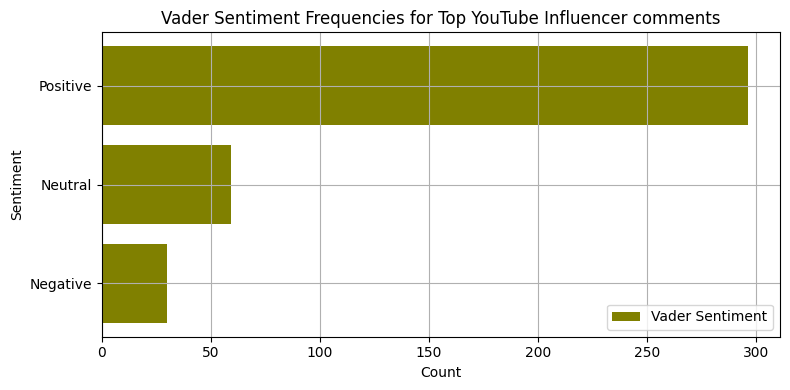

In [70]:
vader_sentiment_counts = df.groupby('vader_sentiment').size()

# Create a single graph for sentiment and Vader sentiment vs frequency
plt.figure(figsize=(8, 4))

# Plot Vader sentiment counts
plt.barh(vader_sentiment_counts.index, vader_sentiment_counts.values, color='olive', label='Vader Sentiment')

plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('Vader Sentiment Frequencies for Top YouTube Influencer comments')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

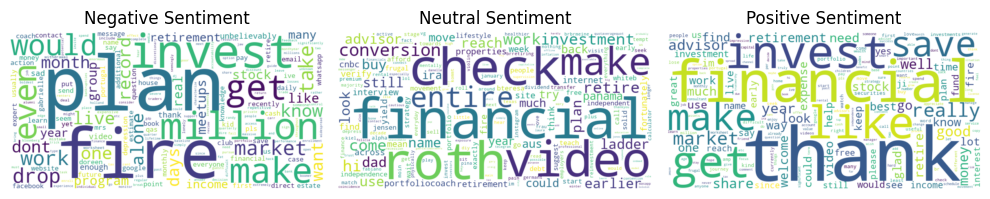

In [71]:
# Group data by sentiment and merge tokens
grouped = df.groupby('vader_sentiment')['lemmatized_tokens'].apply(lambda x: [token for sublist in x for token in sublist])

# Count word frequencies in each sentiment group
word_counts = {sentiment: Counter(tokens) for sentiment, tokens in grouped.items()}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Create word clouds for each sentiment group and display in subplots
for i, (sentiment, counts) in enumerate(word_counts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].axis('off')

# Adjust layout spacing
plt.tight_layout()
plt.show()

In [72]:
# Define a list of words to remove
remove_words = ['would', 'get', 'year', 'go', 'sense', 'sure', 'like', 'seem', 'sound', 'thank']

# Apply a lambda function to remove specified words
df['cleaned_lemmatized_tokens'] = df['lemmatized_tokens'].apply(lambda tokens: [word for word in tokens if word not in remove_words])


# Topic modelling

In [73]:
# Function to create n-grams with space-separated tokens
def create_space_separated_bigrams(text):
    tokens = word_tokenize(text)
    bigrams = list(ngrams(tokens, 2))
    return [' '.join(bigram) for bigram in bigrams]

# Assuming df1 has a column named 'lemmatized_filtered_tokens'
df['space_separated_bigrams'] = df['cleaned_lemmatized_tokens'].apply(lambda tokens: create_space_separated_bigrams(' '.join(tokens)))

BOW method

In [74]:
dictionary = corpora.Dictionary(df['space_separated_bigrams'])

# Create a corpus (bag of words representation) from the unigrams
corpus = [dictionary.doc2bow(bigram) for bigram in df['space_separated_bigrams']]

# Build the LDA model
lda_model_bow = LdaModel(corpus, num_topics= 4, id2word=dictionary, passes=15)

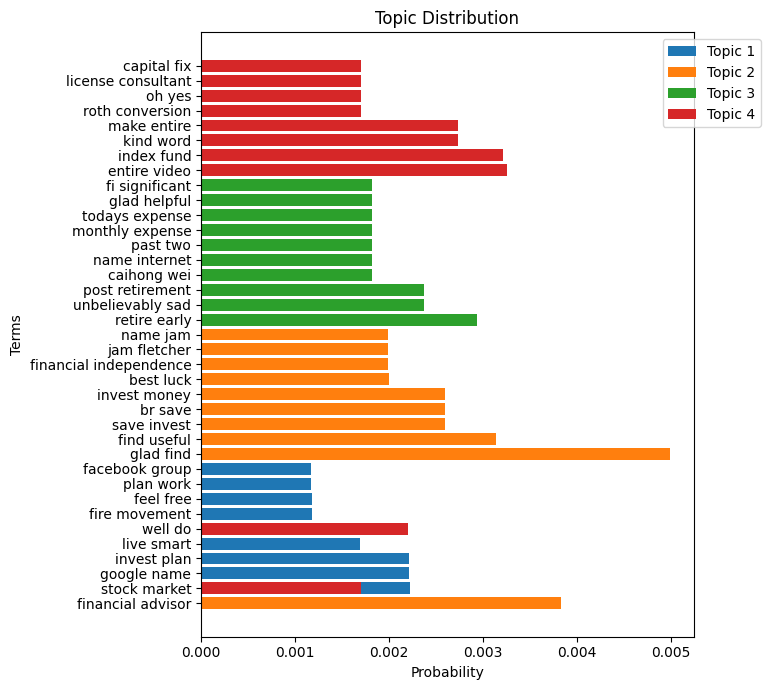

In [75]:
# Get the topic-term matrix
topic_terms = lda_model_bow.get_topics()

# Normalize the topic-term matrix
topic_terms /= topic_terms.sum(axis=1)[:, np.newaxis]

# Get the top terms for each topic
num_top_terms = 10  # You can adjust the number of top terms
top_terms_per_topic = [lda_model_bow.show_topic(topic_id, topn=num_top_terms) for topic_id in range(4)]

# Adjust figure size
plt.figure(figsize=(8,7))

# Create a bar plot for each topic
for topic_id, top_terms in enumerate(top_terms_per_topic):
    terms, probabilities = zip(*top_terms)
    plt.barh(terms, probabilities, label=f"Topic {topic_id + 1}")

plt.xlabel('Probability')
plt.ylabel('Terms')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Topic Distribution')
plt.tight_layout()
plt.show()


In [76]:
for topic_id, top_terms in enumerate(top_terms_per_topic):
    terms, _ = zip(*top_terms)  # Ignore the probabilities
    print(f"Topic {topic_id + 1} :\n {terms}")

Topic 1 :
 ('financial advisor', 'stock market', 'google name', 'invest plan', 'live smart', 'well do', 'fire movement', 'feel free', 'plan work', 'facebook group')
Topic 2 :
 ('glad find', 'financial advisor', 'find useful', 'save invest', 'br save', 'invest money', 'best luck', 'financial independence', 'jam fletcher', 'name jam')
Topic 3 :
 ('retire early', 'unbelievably sad', 'post retirement', 'caihong wei', 'name internet', 'past two', 'monthly expense', 'todays expense', 'glad helpful', 'fi significant')
Topic 4 :
 ('entire video', 'index fund', 'kind word', 'make entire', 'well do', 'stock market', 'roth conversion', 'oh yes', 'license consultant', 'capital fix')


In [77]:

# Set of bigrams to identify
bigrams_to_identify_Topic1 = {'financial advisor', 'stock market', 'invest plan','fire movement'}

# Function to check if a comment contains any of the specified bigrams
def contains_bigrams(comment):
    for bigram in bigrams_to_identify_Topic1:
        if bigram in comment:
            return True
    return False

# Apply the contains_bigrams function to your DataFrame to create a new column
df['Contains_Bigrams_Topic1'] = df['space_separated_bigrams'].apply(contains_bigrams)

# Filter the DataFrame to get comments that contain the specified bigrams
comments_with_bigrams_topic1 = df[df['Contains_Bigrams_Topic1']]

# Count the number of rows where 'Contains_Bigrams' is True
num_comments_with_bigrams_topic1 = len(comments_with_bigrams_topic1)

# Print the number of comments that contain the specified bigrams
print(f"Number of comments that contain the specified bigrams: {num_comments_with_bigrams_topic1}")



Number of comments that contain the specified bigrams: 24


In [79]:

# Find the 5 most positive comments
top_5_positive = comments_with_bigrams_topic1.nlargest(5, 'vader_compound_score')

# Find the 5 most negative comments
top_5_negative = comments_with_bigrams_topic1.nsmallest(5, 'vader_compound_score')

# Display the results
print("5 Most Positive Comments:")
print(top_5_positive[['Comment', 'vader_compound_score']])  

print("\n5 Most Negative Comments:")
print(top_5_negative[['Comment', 'vader_compound_score']])  


5 Most Positive Comments:
                                               Comment  vader_compound_score
320  This video perfectly captures the essence of t...                0.9698
110  Well, I can share some that helped me. \r<br>1...                0.9652
259  Well, I can share some that helped me. \r<br>1...                0.9652
255  @steph meldrich 1: Plan with a Financial Advis...                0.9360
127  It is easy, get yourself a good financial advi...                0.8979

5 Most Negative Comments:
                                               Comment  vader_compound_score
117  ▸▸▸ https://www.365daystofire.com/\nEnrollment...               -0.2732
125  The market is out of control, and banks are fa...               -0.2500
335  Hi. May I suggest you employ the services of a...                0.0000
118  I’m currently retired, and considering the cur...                0.0516
146  This is really nice. I worry that I have a cou...                0.0553


In [80]:
comments_with_bigrams_topic1.to_csv("Topic1_Comments.csv", index = False)

In [81]:
# Set of bigrams to identify
bigrams_to_identify_Topic2 = {'invest money', 'financial independence', 'financial advisor'}

# Function to check if a comment contains any of the specified bigrams
def contains_bigrams(comment):
    for bigram in bigrams_to_identify_Topic2:
        if bigram in comment:
            return True
    return False

# Apply the contains_bigrams function to your DataFrame to create a new column
df['Contains_Bigrams_Topic2'] = df['space_separated_bigrams'].apply(contains_bigrams)

# Filter the DataFrame to get comments that contain the specified bigrams
comments_with_bigrams_topic2 = df[df['Contains_Bigrams_Topic2']]

# Count the number of rows where 'Contains_Bigrams' is True
num_comments_with_bigrams_topic2 = len(comments_with_bigrams_topic2)

# Print the number of comments that contain the specified bigrams
print(f"Number of comments that contain the specified bigrams: {num_comments_with_bigrams_topic2}")



Number of comments that contain the specified bigrams: 22


In [82]:

# Find the 5 most positive comments
top_5_positive = comments_with_bigrams_topic2.nlargest(5, 'vader_compound_score')

# Find the 5 most negative comments
top_5_negative = comments_with_bigrams_topic2.nsmallest(5, 'vader_compound_score')

# Display the results
print("5 Most Positive Comments:")
print(top_5_positive[['Comment', 'vader_compound_score']])  

print("\n5 Most Negative Comments:")
print(top_5_negative[['Comment', 'vader_compound_score']])  


5 Most Positive Comments:
                                               Comment  vader_compound_score
68   Wow, this video is a game-changer! 🚀 The step-...                0.9732
320  This video perfectly captures the essence of t...                0.9698
110  Well, I can share some that helped me. \r<br>1...                0.9652
259  Well, I can share some that helped me. \r<br>1...                0.9652
255  @steph meldrich 1: Plan with a Financial Advis...                0.9360

5 Most Negative Comments:
                                               Comment  vader_compound_score
76   Financial depression is a type of depression t...               -0.9300
109  FIRE means Financial Independence Retire Early...               -0.0000
258  FIRE means Financial Independence Retire Early...               -0.0000
335  Hi. May I suggest you employ the services of a...                0.0000
146  This is really nice. I worry that I have a cou...                0.0553


In [ ]:
comments_with_bigrams_topic2.to_csv("Topic2_Comments.csv", index = False)

In [83]:
# Set of bigrams to identify
bigrams_to_identify_Topic3 = {'retire early', 'post retirement'}

# Function to check if a comment contains any of the specified bigrams
def contains_bigrams(comment):
    for bigram in bigrams_to_identify_Topic1:
        if bigram in comment:
            return True
    return False

# Apply the contains_bigrams function to your DataFrame to create a new column
df['Contains_Bigrams_Topic3'] = df['space_separated_bigrams'].apply(contains_bigrams)

# Filter the DataFrame to get comments that contain the specified bigrams
comments_with_bigrams_topic3 = df[df['Contains_Bigrams_Topic3']]

# Count the number of rows where 'Contains_Bigrams' is True
num_comments_with_bigrams_topic3 = len(comments_with_bigrams_topic3)

# Print the number of comments that contain the specified bigrams
print(f"Number of comments that contain the specified bigrams: {num_comments_with_bigrams_topic3}")



Number of comments that contain the specified bigrams: 24


In [84]:

# Find the 5 most positive comments
top_5_positive = comments_with_bigrams_topic3.nlargest(5, 'vader_compound_score')

# Find the 5 most negative comments
top_5_negative = comments_with_bigrams_topic3.nsmallest(5, 'vader_compound_score')

# Display the results
print("5 Most Positive Comments:")
print(top_5_positive[['Comment', 'vader_compound_score']])  

print("\n5 Most Negative Comments:")
print(top_5_negative[['Comment', 'vader_compound_score']])  

5 Most Positive Comments:
                                               Comment  vader_compound_score
320  This video perfectly captures the essence of t...                0.9698
110  Well, I can share some that helped me. \r<br>1...                0.9652
259  Well, I can share some that helped me. \r<br>1...                0.9652
255  @steph meldrich 1: Plan with a Financial Advis...                0.9360
127  It is easy, get yourself a good financial advi...                0.8979

5 Most Negative Comments:
                                               Comment  vader_compound_score
117  ▸▸▸ https://www.365daystofire.com/\nEnrollment...               -0.2732
125  The market is out of control, and banks are fa...               -0.2500
335  Hi. May I suggest you employ the services of a...                0.0000
118  I’m currently retired, and considering the cur...                0.0516
146  This is really nice. I worry that I have a cou...                0.0553


In [85]:
comments_with_bigrams_topic3.to_csv("Topic3_Comments.csv", index = False)